## Notebook for connecting the new architecture with the HPO framework

In [1]:
import sys
import os
import yaml
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from quantumenvironment import QuantumEnvironment
from agent import Agent
from gate_level_abstraction import gate_q_env_config
from helper_functions import load_agent_from_yaml_file
from ppo import make_train_ppo

/Users/lukasvoss/Library/Python/3.9/lib/python/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'measure', 'z', 'tdg', 'delay', 'rz', 's', 'x', 't', 'reset', 'sdg', 'h', 'id', 'sx'}
  q1: {'measure', 'z', 'tdg', 'delay', 'rz', 's', 'x', 't', 'reset', 'sdg', 'h', 'id', 'sx'}
Multi qubit instructions:
  (0, 1): {'ecr', 'cr45p', 'cr45m'}
  (1, 0): {'ecr', 'cr45p', 'cr45m'}
)>
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done fo

In [2]:
gate_q_env_config.action_space

Box(-1.0, 1.0, (7,), float32)

In [3]:
# from gymnasium.wrappers.rescale_action import RescaleAction

# min_action = 0
# max_action = 1
# wrapped_env = RescaleAction(q_env, min_action=min_action, max_action=max_action)

### Import HPO Params from YAML file

In [4]:
ppo_params, network_config, hpo_config = load_agent_from_yaml_file('agent_config.yaml')

In [5]:
ppo_params

{'run_name': 'test',
 'n_updates': 1,
 'n_epochs': 12,
 'batch_size': 24,
 'learning_rate': 0.01,
 'gamma': 0.99,
 'gae_lambda': 0.95,
 'ent_coef': 0.01,
 'vf_coef': 0.5,
 'max_grad_norm': 5.0,
 'clip_range_vf': True,
 'clip_range': 0.2}

In [6]:
network_config

{'optimizer': 'adam',
 'n_units': [64, 64],
 'activation': 'tanh',
 'include_critic': True,
 'normalize_advantage': True,
 'checkpoint_dir': 'checkpoints'}

In [7]:
hpo_config

{'num_trials': 10,
 'n_epochs': [250, 2000],
 'minibatch_size': [16, 32, 48, 64, 96, 128],
 'batchsize_multiplier': [2, 12],
 'learning_rate': [0.001, 0.02],
 'gamma': [0.95, 0.99],
 'gae_lambda': [0.9, 0.99],
 'ent_coef': [0.005, 0.02],
 'v_coef': [0.25, 0.75],
 'max_grad_norm': [0.005, 1],
 'clip_value_loss': [False, True],
 'clip_value_coef': [0.1, 0.3],
 'clip_ratio': [0.1, 0.3]}

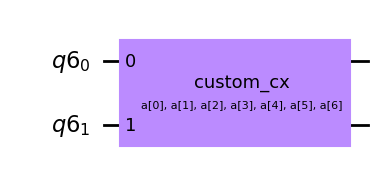

In [8]:
q_env = QuantumEnvironment(gate_q_env_config)
q_env
q_env.parameters.params
q_env.circuit_truncations[0].draw('mpl')

In [9]:
def objective(trial):
    # Fetch hyperparameters from the trial object

    agent_config = {
        'N_UPDATES': trial.suggest_int('N_UPDATES', hpo_config['n_updates'][0], hpo_config['n_updates'][1]),
        'N_EPOCHS': trial.suggest_int('N_EPOCHS', hpo_config['n_epochs'][0], hpo_config['n_epochs'][1]),
        'MINIBATCH_SIZE': trial.suggest_categorical('MINIBATCH_SIZE', hpo_config['minibatch_size']),
        'BATCHSIZE_MULTIPLIER': trial.suggest_int('BATCHSIZE_MULTIPLIER', hpo_config['batchsize_multiplier'][0], hpo_config['batchsize_multiplier'][1]),
        'LR': trial.suggest_float('LR', hpo_config['learning_rate'][0], hpo_config['learning_rate'][1], log=True),
        'GAMMA': trial.suggest_float('GAMMA', hpo_config['gamma'][0], hpo_config['gamma'][1]),
        'GAE_LAMBDA': trial.suggest_float('GAE_LAMBDA', hpo_config['gae_lambda'][0], hpo_config['gae_lambda'][1]),
        'ENT_COEF': trial.suggest_float('ENT_COEF', hpo_config['ent_coef'][0], hpo_config['ent_coef'][1]),
        'V_COEF': trial.suggest_float('V_COEF', hpo_config['v_coef'][0], hpo_config['v_coef'][1]),
        'GRADIENT_CLIP': trial.suggest_float('GRADIENT_CLIP', hpo_config['max_grad_norm'][0], hpo_config['max_grad_norm'][1]),
        'CLIP_VALUE_LOSS': trial.suggest_categorical('CLIP_VALUE_LOSS', hpo_config['clip_value_loss']),
        'CLIP_VALUE_COEF': trial.suggest_float('CLIP_VALUE_COEF', hpo_config['clip_value_coef'][0], hpo_config['clip_value_coef'][1]),
        'CLIP_RATIO': trial.suggest_float('CLIP_RATIO', hpo_config['clip_ratio'][0], hpo_config['clip_ratio'][1]),
    }

    # Allowing for a range of possible batchsize / minibatch_size combinations by ensuring that batchsize is a multiple of minibatch_size
    agent_config['BATCHSIZE'] = agent_config['MINIBATCH_SIZE'] * agent_config['BATCHSIZE_MULTIPLIER']

    # Add network-specific hyperparameters that are not part of HPO scope
    agent_config['OPTIMIZER'] = network_config['optimizer']
    agent_config['N_UNITS'] = network_config['n_units']
    agent_config['ACTIVATION'] = network_config['activation']
    agent_config['INCLUDE_CRITIC'] = network_config['include_critic']
    agent_config['NORMALIZE_ADVANTAGE'] = network_config['normalize_advantage']

    agent_config['RUN_NAME'] = ppo_params['run_name']


    q_env = QuantumEnvironment(gate_q_env_config)  # Initialize your environment
    q_env.batch_size = agent_config['BATCHSIZE'] # Overwrite the batch_size of the environment with the one from the agent_config

    train_fn = make_train_ppo(agent_config, q_env)
    training_results = train_fn(total_updates=25, print_debug=False, num_prints=50)

    # Save the action vector associated with this trial's fidelity for future retrieval
    trial.set_user_attr('action_vector', training_results['action_vector'])

    # Use a relevant metric from training_results as the return value
    last_ten_percent = int(0.1 * agent_config['N_EPOCHS'])
    
    return last_ten_percent  # Return a metric to minimize or maximize

In [10]:
import optuna

num_HPO_trials = hpo_config['num_trials']
print('num_HPO_trials: ', num_HPO_trials)

def optimize_hyperparameters():
    study = optuna.create_study(direction="maximize")  # or 'minimize' depending on your metric
    study.optimize(objective, n_trials=num_HPO_trials)  # Number of hyperparameter configurations to try

    print("Best trial:")
    best_trial = study.best_trial

    print("  Value: ", best_trial.value)
    print("  Parameters: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    best_action_vector = best_trial.user_attrs['action_vector']
    print(f'The best action vector is: {best_action_vector}')

optimize_hyperparameters()

[I 2023-12-21 17:58:27,395] A new study created in memory with name: no-name-df3d513e-a213-48cf-a14c-213227d80ec6


num_HPO_trials:  10


  0%|          | 0/25 [00:00<?, ?it/s]

SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


  4%|▍         | 1/25 [00:11<04:42, 11.77s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


  8%|▊         | 2/25 [00:22<04:16, 11.17s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])


/Users/lukasvoss/Library/Python/3.9/lib/python/site-packages/qiskit_aer/primitives/estimator.py:446: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(combined_var / shots)
 12%|█▏        | 3/25 [00:33<04:01, 10.99s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 16%|█▌        | 4/25 [00:44<03:48, 10.90s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])


 20%|██        | 5/25 [00:54<03:36, 10.85s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 24%|██▍       | 6/25 [01:05<03:25, 10.80s/it]

Fidelity History: []
SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 28%|██▊       | 7/25 [01:16<03:14, 10.79s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 32%|███▏      | 8/25 [01:27<03:04, 10.83s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])


 36%|███▌      | 9/25 [01:38<02:53, 10.86s/it]

Fidelity History: []
Starting benchmarking...


Adding a job from a backend (aer_simulator) that is different than the current backend (<qiskit.providers.fake_provider.backends.jakarta.fake_jakarta.FakeJakartaV2 object at 0x2d18b0070>). The new backend will be used, but service is not changed if one already exists.


Finished benchmarking
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 40%|████      | 10/25 [45:29<3:24:57, 819.86s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j])


 44%|████▍     | 11/25 [45:40<2:13:30, 572.20s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 48%|████▊     | 12/25 [45:50<1:26:57, 401.33s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 52%|█████▏    | 13/25 [46:01<56:36, 283.07s/it]  

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 56%|█████▌    | 14/25 [46:13<36:51, 201.02s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j])


/Users/lukasvoss/Library/Python/3.9/lib/python/site-packages/qiskit_aer/primitives/estimator.py:446: RuntimeWarning: invalid value encountered in sqrt
  standard_error = np.sqrt(combined_var / shots)
 60%|██████    | 15/25 [46:23<23:55, 143.58s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 64%|██████▍   | 16/25 [46:33<15:31, 103.50s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])


 68%|██████▊   | 17/25 [46:44<10:04, 75.60s/it] 

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])


 72%|███████▏  | 18/25 [46:55<06:32, 56.03s/it]

Fidelity History: [0.26475826336639563]
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 76%|███████▌  | 19/25 [47:05<04:14, 42.37s/it]

Fidelity History: [0.26475826336639563]
Starting benchmarking...


Adding a job from a backend (aer_simulator) that is different than the current backend (<qiskit.providers.fake_provider.backends.jakarta.fake_jakarta.FakeJakartaV2 object at 0x2d18b0070>). The new backend will be used, but service is not changed if one already exists.


Finished benchmarking
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])


 80%|████████  | 20/25 [1:08:50<35:07, 421.43s/it]

Fidelity History: [0.26475826336639563, 0.2719203611305955]
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])


 84%|████████▍ | 21/25 [1:09:01<19:52, 298.21s/it]

Fidelity History: [0.26475826336639563, 0.2719203611305955]
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 88%|████████▊ | 22/25 [1:09:12<10:35, 211.90s/it]

Fidelity History: [0.26475826336639563, 0.2719203611305955]
SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])


 92%|█████████▏| 23/25 [1:09:22<05:02, 151.45s/it]

Fidelity History: [0.26475826336639563, 0.2719203611305955]
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j])


 96%|█████████▌| 24/25 [1:09:34<01:49, 109.62s/it]

Fidelity History: [0.26475826336639563, 0.2719203611305955]
SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


100%|██████████| 25/25 [1:09:45<00:00, 167.41s/it]
[I 2023-12-21 19:08:12,588] Trial 0 finished with value: 165.0 and parameters: {'N_EPOCHS': 1654, 'MINIBATCH_SIZE': 48, 'BATCHSIZE_MULTIPLIER': 9, 'LR': 0.0027718308864752655, 'GAMMA': 0.9536513260678077, 'GAE_LAMBDA': 0.9530957797916122, 'ENT_COEF': 0.019851676737286685, 'V_COEF': 0.6955661901828224, 'GRADIENT_CLIP': 0.297114906444653, 'CLIP_VALUE_LOSS': False, 'CLIP_VALUE_COEF': 0.1747094606396171, 'CLIP_RATIO': 0.15632249538152446}. Best is trial 0 with value: 165.0.


Fidelity History: [0.26475826336639563, 0.2719203611305955]


  0%|          | 0/25 [00:00<?, ?it/s]

SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


  4%|▍         | 1/25 [00:09<03:42,  9.28s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


  8%|▊         | 2/25 [00:19<03:45,  9.82s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j])


 12%|█▏        | 3/25 [00:28<03:26,  9.38s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 16%|█▌        | 4/25 [00:37<03:11,  9.13s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'XI', 'XZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 20%|██        | 5/25 [00:45<02:59,  8.95s/it]

Fidelity History: []
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 24%|██▍       | 6/25 [00:54<02:48,  8.89s/it]

Fidelity History: []
SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])


 28%|██▊       | 7/25 [01:03<02:38,  8.82s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


 32%|███▏      | 8/25 [01:11<02:28,  8.71s/it]

Fidelity History: []
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])


 36%|███▌      | 9/25 [01:20<02:19,  8.74s/it]

Fidelity History: []
Starting benchmarking...


Exception ignored in: <function _xla_gc_callback at 0x296009550>
Traceback (most recent call last):
  File "/Users/lukasvoss/Library/Python/3.9/lib/python/site-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
